In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Setup

In [12]:
import os, sys
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))
from utils import DATA_DIR, ROOT_DIR, PLOT_DIR

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from dataloader import get_nd_array, get_slice
from download.hf import pull_predictions_from_hf

import ladder_wrapper
plt.close()

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)  # ignore fitting warnings

In [13]:
local_path = f'{DATA_DIR}/data/benchmarks-00000-of-00001.parquet'

df = pd.read_parquet(local_path)
print(f'Loaded {len(df):,} model evaluations')

# fix for the names of one of Ian's data mixes
df.loc[df['mix'] == 'baseline', 'mix'] = 'dolma17'

Loaded 810,570 model evaluations


In [4]:
def task_tag(task_name):
    return task_name.split("::")[0].replace(":rc", "") if "::" in task_name else task_name

MODELS = list(df['model'].unique())
MIXES = list(df['mix'].unique())
STEPS = list(df['step'].unique())
TASKS = sorted(list(df['task'].unique()))

In [5]:
from ladder_wrapper import sort_experiment_names
from utils.constants_models import MODEL_LIST_MIXES
from utils.constants_models import DDOS_MODEL_NAMES

# Train models
all_ladder_models = [model for model in MODELS if 'peteish-moreeval' in model]
all_ladder_models = sort_experiment_names(all_ladder_models)

# Ladder config
ladder_config_path = f'{ROOT_DIR}/analysis/utils/ladder_config.json'

# Eval models
MODEL_LIST_MIXES = [model.split("/")[-1] for model in MODEL_LIST_MIXES]
BROKEN_MODELS = ["gemma-2b", "gemma-7b", "gemma-2-2b", "gemma-2-9b"] # gemma models broken in oe-eval
LLAMA_3_MODELS = [model for model in MODELS if 'Meta-Llama-3' in model]

all_models = sorted([model for model in MODELS if model not in DDOS_MODEL_NAMES + MODEL_LIST_MIXES + BROKEN_MODELS + all_ladder_models])

### Select Tasks

In [6]:
from utils import get_selected_tasks


selected_tasks = [
    t
    for t in TASKS
    if ":" not in t 
    and "bbh" not in t and "paloma" not in t and "llm_compression" not in t 
    and "custom_loss" not in t and "coqa" not in t and "deepmind" not in t
]

selected_tasks += [
    t
    for t in TASKS
    if ":mc" in t
    and "bbh" not in t and "paloma" not in t and "llm_compression" not in t
    and "custom_loss" not in t and "coqa" not in t and "deepmind" not in t
]

mmlu      = [t for t in TASKS if 'mmlu' in t and ':' not in t and '_pro_' not in t]
minerva   = [t for t in TASKS if 'minerva' in t and ':' not in t]
mmlu_pro  = [t for t in TASKS if '_pro_' in t and ':rc' in t]
mmlu_mc   = [t for t in TASKS if 'mmlu' in t and ':mc' in t and '_pro_' not in t]
olmes     = ['arc_challenge', 'arc_easy', 'boolq', 'csqa', 'hellaswag', 'openbookqa', 'piqa', 'socialiqa', 'winogrande']
olmes_mc  = [f'{task}:mc' for task in olmes]
olmes_para        = [f'{task}:para' for task in olmes]
olmes_distractors = [f'{task}:distractors' for task in olmes]
olmes_enlarge     = [f'{task}:enlarge' for task in olmes]
# olmes_gen = ['drop', 'gsm8k', 'jeopardy', 'naturalqs', 'squad', 'triviaqa']
olmes_gen = ['drop', 'gsm8k', 'jeopardy', 'squad', 'triviaqa']
agi_eval  = [t for t in TASKS if 'agi_eval' in t and ':' not in t]
bbh       = [t for t in TASKS if 'bbh' in t and ':' not in t]
paloma    = [t for t in TASKS if 'paloma' in t]
llm_compression = [t for t in TASKS if 'llm_compression' in t]
custom_loss = [t for t in TASKS if 'custom_loss' in t]

# task suites
multitask_math = ["gsm_plus", "gsm_symbolic_main", "gsm_symbolic_p1", "gsm_symbolic_p2", "minerva_math_500", "aime"] # 6
multitask_code = ['mbpp', 'mbppplus', 'codex_humaneval', 'codex_humanevalplus'] # 4
multitask_knowledge = ["medmcqa", 'autobencher'] + olmes + mmlu + olmes_gen + mmlu_pro + agi_eval # 19
multitask = multitask_knowledge + multitask_math + multitask_code + bbh # 30
olmes_all = olmes + mmlu + olmes_gen

# selected_tasks = olmes + olmes_gen + [olmes, olmes_para, olmes_distractors, olmes_enlarge, mmlu, olmes_mc, mmlu_mc, olmes_gen, minerva]
selected_tasks = olmes + olmes_gen + [olmes, mmlu, olmes_mc, mmlu_mc, olmes_gen, minerva]
selected_tasks += ['gsm_symbolic_main', mmlu_pro, 'autobencher', 'autobencher:mc']
# selected_tasks += ['minerva_math_500', 'mbpp', 'mbppplus', 'codex_humaneval', 'codex_humanevalplus', 'copycolors:mc']
selected_tasks += ['minerva_math_500', 'mbpp', 'mbppplus', 'codex_humaneval', 'codex_humanevalplus']

# selected_tasks = olmes + olmes_para + olmes_distractors + olmes_enlarge

selected_tasks = get_selected_tasks(TASKS)

### Meta-evaluate Benchmarks

In [7]:
from ladder_wrapper import run_ladder
from metaanalysis import get_title_from_task
from utils import get_pretty_task_name
from utils.constants_models import DDOS_MODEL_NAMES
import math
plt.close()

In [8]:
from download.preprocess import is_excluded_from_lite
external_models = [model for model in all_models if not is_excluded_from_lite(model)]

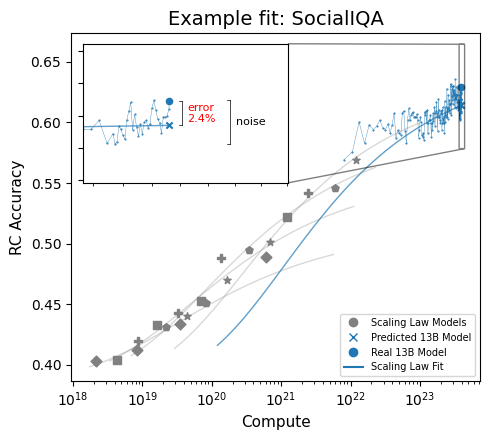

In [9]:
from metaanalysis import get_title_from_task, set_title_from_task
plt.close()

def _plt_stacked_predictions_clean(ax: plt.Axes, task):
    ## Stacked ladder prediction
    (_, _, stacked_error), (_, _, stacked_y), (_, _, stacked_y_pred) = run_ladder(
        df,
        task,
        train_models=all_ladder_models,
        # train_models=all_ladder_models + LLAMA_3_MODELS,
        eval_models=["peteish13-highlr"],
        config_path=ladder_config_path,
        plot_compute=True,
        run_step1=False, run_step2=False,
        axes=[ax],
        return_reals=True
    )
    
    ax.get_legend().remove()

    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='grey', label='Scaling Law Models', linestyle='None'),
        Line2D([0], [0], marker='x', color='#1f77b4', label='Predicted 13B Model', linestyle='None'),
        Line2D([0], [0], marker='o', color='#1f77b4', label='Real 13B Model', linestyle='None'),
        Line2D([0], [0], color='#1f77b4', label='Scaling Law Fit', linestyle='-'),
    ]
    ax.legend(handles=legend_elements, fontsize=7, loc='lower right')

    stacked_y_pred = stacked_y_pred[0]

    return stacked_error, stacked_y, stacked_y_pred


def _plt_intermediate_checkpoints_13b(ax: plt.Axes, task, metric='primary_score'):
    ### intermediate checkpoints
    step, scores = get_nd_array(df, ['task', 'step'], metric, model='peteish13-highlr', task=task)

    if len(scores.shape) > 1:
        scores = np.mean(scores, axis=-1)

    step = np.array(step, dtype=np.float64)
    scores = np.array(scores, dtype=np.float64)

    compute = (step / max(step)) * 6*13202396160*5000088518656

    x = compute[3:]
    y = scores[3:]
    
    x, y = np.array(x), np.array(y)
    sorted_indices = np.argsort(x)
    x = x[sorted_indices]
    y = y[sorted_indices]

    ax.plot(x, y, color='#1f77b4', linewidth=0.25, marker='.', markersize=1)

    final_scores = y[-30:]
    return final_scores


def _plot_with_inset(ax: plt.Axes, task, task_y, task_title):
    _plt_stacked_predictions_clean(ax, task)
    _plt_intermediate_checkpoints_13b(ax, task)

    # Increase range by 10%
    y_min, y_max = ax.get_ylim()
    y_range = y_max - y_min
    ax.set_ylim(y_min, y_max + y_range * 0.1)

    axins = ax.inset_axes([0.03, 0.57, 0.5, 0.4])
    
    stacked_error, stacked_y, stacked_y_pred = _plt_stacked_predictions_clean(axins, task)
    final_scores = _plt_intermediate_checkpoints_13b(axins, task)

    y1_final, y2_final = max(final_scores), min(final_scores)
    mid_final = (y1_final + y2_final) / 2

    y1, y2 = stacked_y, stacked_y_pred
    mid = (y1 + y2) / 2
    
    x_min, x_max = ax.get_xlim()
    y_min, y_max = ax.get_ylim()
    zoom_x_min = x_min + (x_max - x_min) * 0.5 # 0.3
    y_range = (y_max - y_min) * 0.15
    axins.set_xlim(zoom_x_min, x_max*0.6) # 0.45
    axins.set_ylim(mid-y_range, mid+y_range)
    axins.set_xticklabels([])
    axins.set_yticklabels([])
    axins.tick_params(axis='x', which='both', labelbottom=False)
    
    ax.indicate_inset_zoom(axins, edgecolor="black")

    ### Add bracket

    x_pos = axins.get_xlim()[1] * 0.91 # 0.5
    
    axins.plot([x_pos, x_pos], [y1, y2], 'k-', linewidth=0.5)
    axins.plot([x_pos-x_pos*0.0025, x_pos], [y1, y1], 'k-', linewidth=0.5)  # Top horizontal line
    axins.plot([x_pos-x_pos*0.0025, x_pos], [y2, y2], 'k-', linewidth=0.5)  # Bottom horizontal line
    
    error_pct = abs(y2 - y1) / y1 * 100
    axins.text(x_pos+x_pos*0.005, mid, f'error\n{error_pct:.1f}%', 
                verticalalignment='center', fontsize=8, color='r')
    
    # Add margin of error bracket
    x_pos2 = axins.get_xlim()[1] * 0.95

    axins.plot([x_pos2, x_pos2], [y1_final, y2_final], 'k-', linewidth=0.5)
    axins.plot([x_pos2-x_pos2*0.0025, x_pos2], [y1_final, y1_final], 'k-', linewidth=0.5)
    axins.plot([x_pos2-x_pos2*0.0025, x_pos2], [y2_final, y2_final], 'k-', linewidth=0.5)
    
    error_pct_final = abs(y2_final - y1_final) / y1_final * 100
    axins.text(x_pos2+x_pos2*0.005, mid_final, 
               'noise', 
               # 'std.\ndev.', 
               # f'margin\nof\nerror', 
               verticalalignment='center', fontsize=8, color='k')

    axins.set_title("")
    axins.set_xlabel("")
    axins.set_ylabel("")
    axins.get_legend().remove() if axins.get_legend() is not None else None

    ax.set_title(task_title, fontsize=14)
    ax.set_xlabel('Compute', fontsize=12)
    ax.set_ylabel(task_y, fontsize=12)


# selected_tasks = ['arc_easy:mc', 'jeopardy', 'openbookqa', 'codex_humanevalplus']
# task_labels = ['ARC Easy (MCQA Format)', 'Jeopardy', 'OpenBookQA', 'HumanEval+']
# task_y = ['MC Accuracy', 'Exact Match', 'RC Accuracy', 'pass@1']

# selected_tasks = ['triviaqa', 'hellaswag', 'openbookqa', 'medmcqa']
# task_labels = ['TriviaQA', 'HellaSwag', 'OpenBookQA', 'MedMCQA']
# task_y = ['Exact Match', 'RC Accuracy', 'RC Accuracy', 'RC Accuracy']

# selected_tasks = ['triviaqa', 'socialiqa', 'openbookqa', 'mbppplus']
# task_labels = ['TriviaQA', 'SocialIQA', 'OpenBookQA', 'MBPP+']
# task_y = ['Exact Match', 'RC Accuracy', 'RC Accuracy', 'pass@1']

# selected_tasks = [multitask_knowledge]
# task_labels = ['Knowledge Tasks (19 Task Average)']
# task_y = ['RC Accuracy']

# fig, axes = plt.subplots(2, 2, figsize=(4*2, 3.5*2))
# axes = axes.flatten()

selected_tasks = ['socialiqa']
task_labels = ['Example fit: SocialIQA']
task_y = ['RC Accuracy']

fig, axes = plt.subplots(1, 1, figsize=(5, 4.5))
axes = [axes]

for i, task in enumerate(selected_tasks):
    ax = axes[i]
    
    _plot_with_inset(
        ax, 
        task,
        task_y[i],
        task_labels[i],
    )

    if i == 3:
        ax.get_legend().remove() if ax.get_legend() is not None else None


    # override for single plot
    ax.title.set_size(14)
    ax.xaxis.label.set_size(11)
    ax.yaxis.label.set_size(11)

fig.tight_layout()
plt.savefig(f'{PLOT_DIR}/prediction_error_example.pdf', bbox_inches='tight', dpi=300)
plt.show()

100%|██████████| 31/31 [01:05<00:00,  2.10s/it]


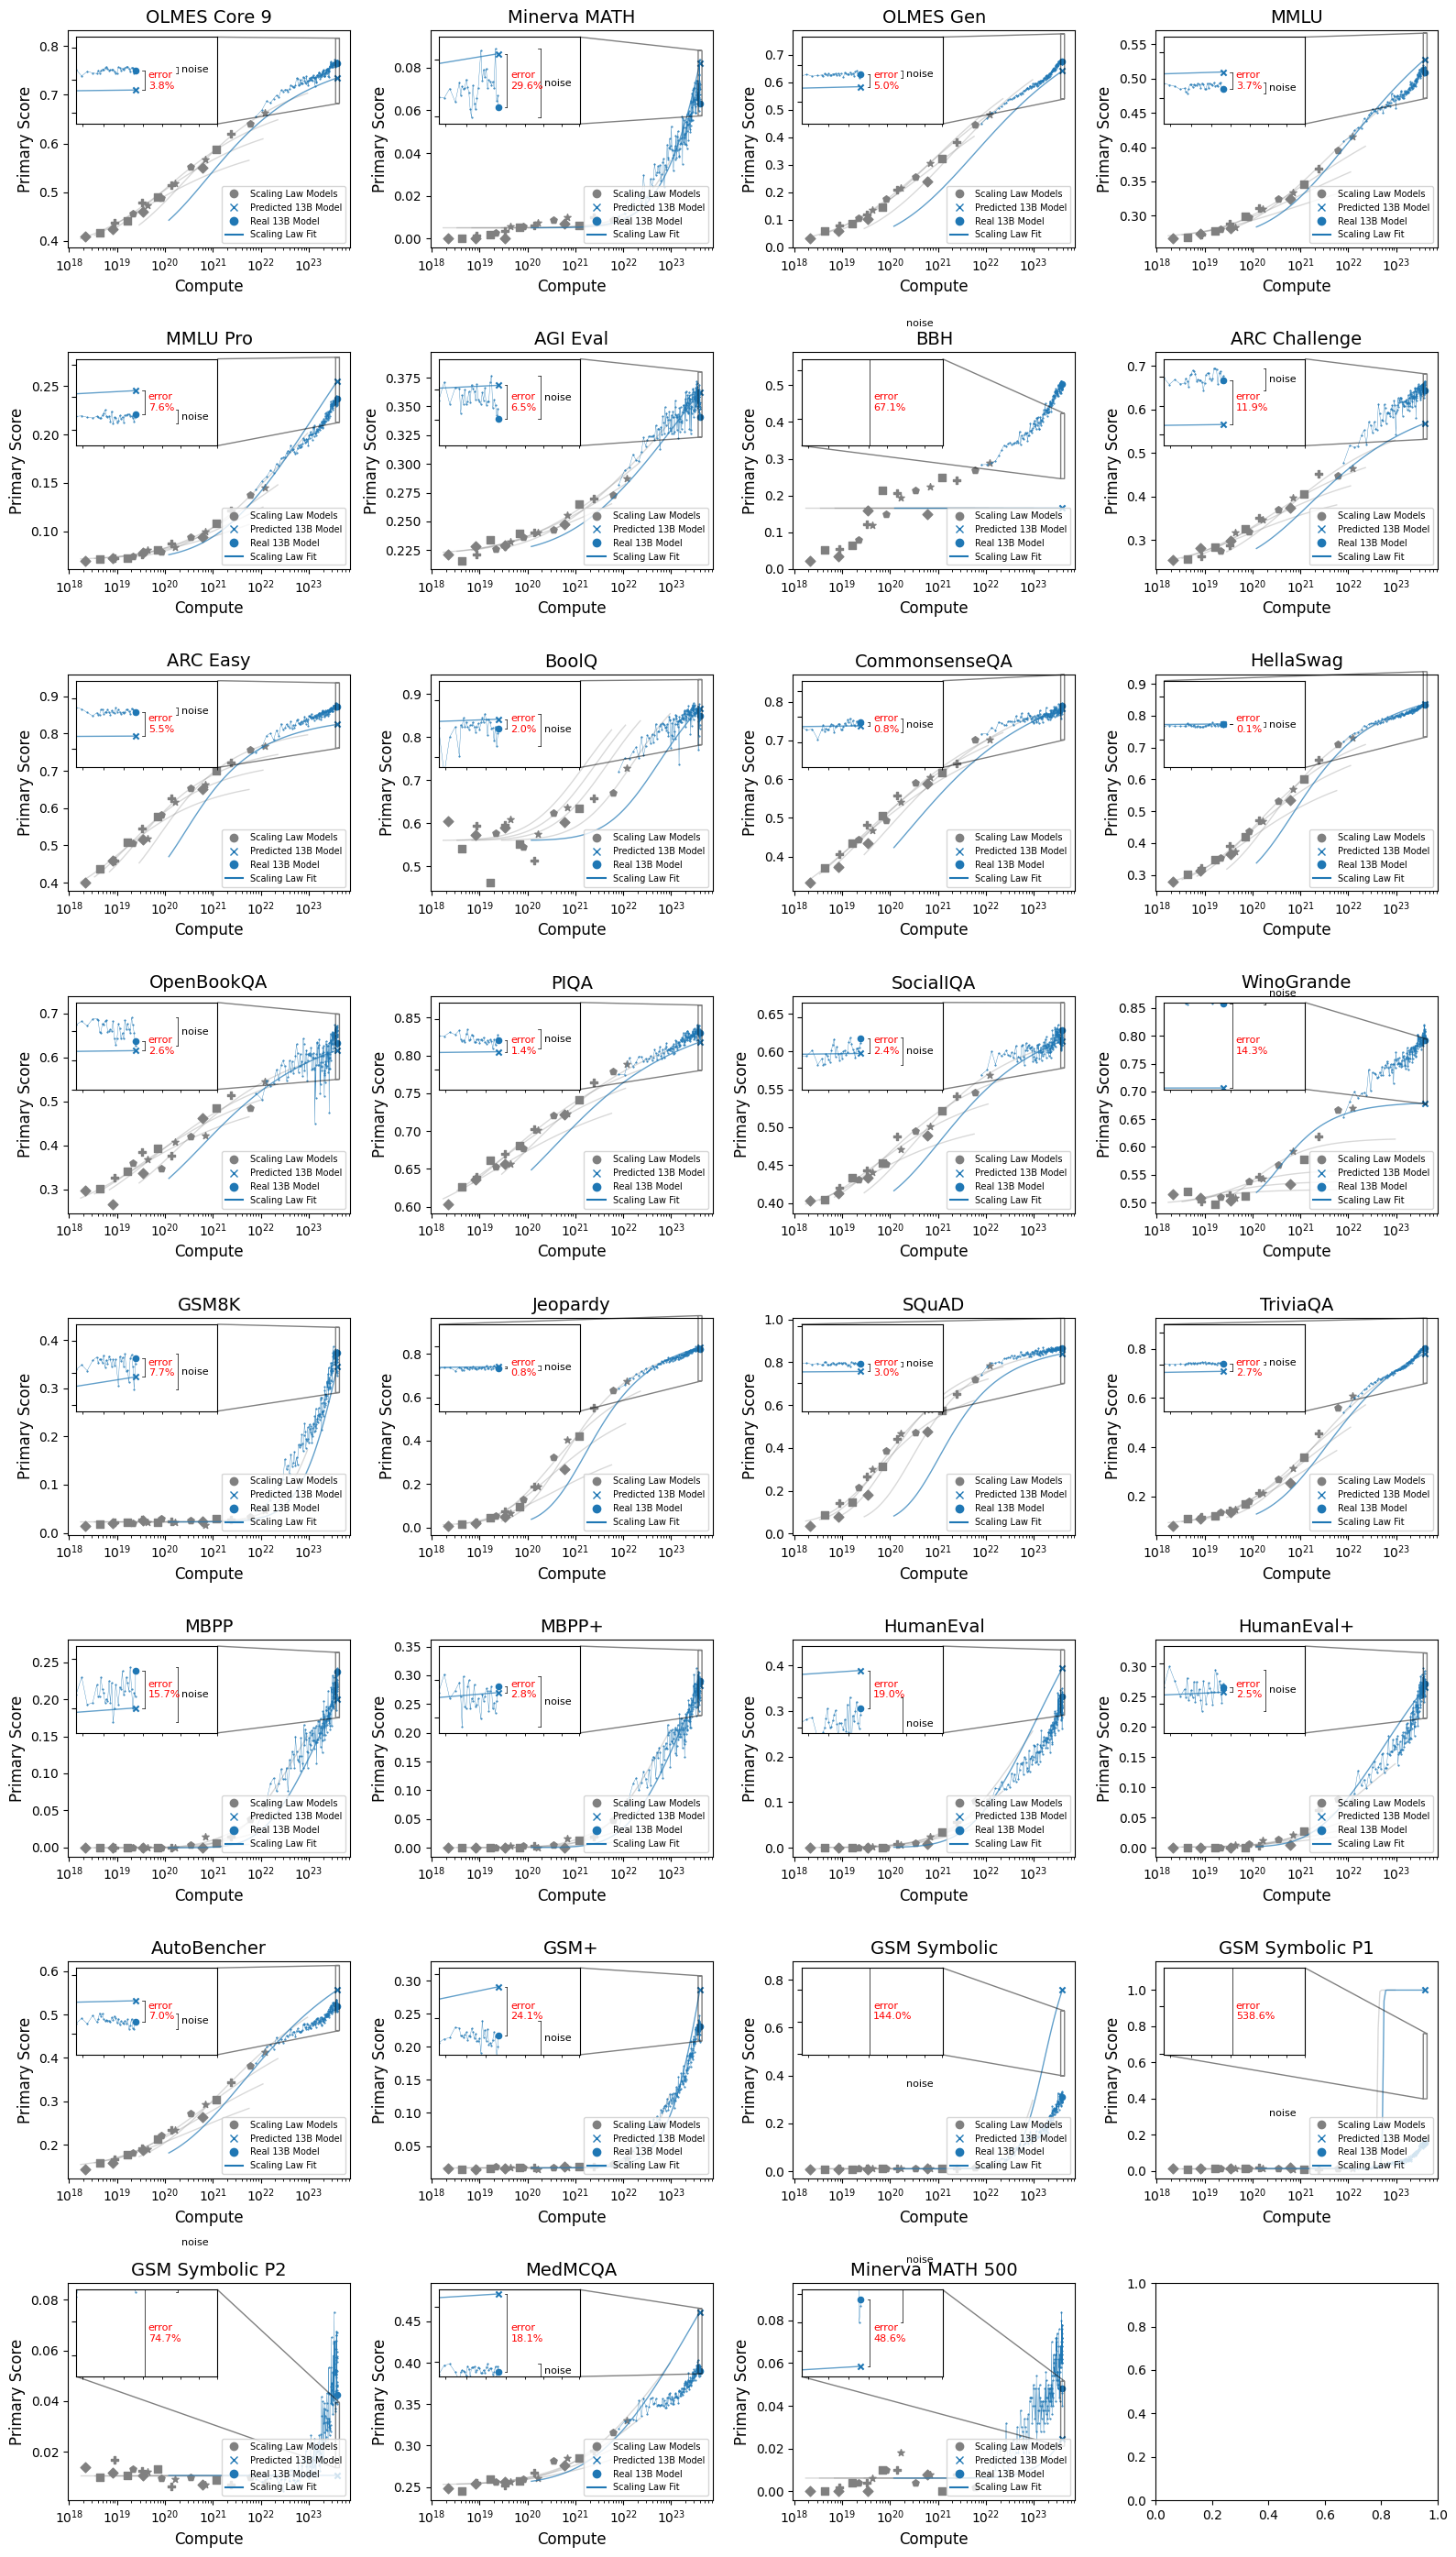

In [10]:
from utils import get_pretty_task_name

# selected_tasks = olmes + olmes_gen
# selected_tasks += ['minerva_math_500', 'mbpp', 'mbppplus', 'codex_humaneval', 'codex_humanevalplus']

selected_tasks = get_selected_tasks(TASKS)

selected_tasks = [task for task in selected_tasks if task != 'drop']

task_y = ['Primary Score' for _ in selected_tasks]

N_ROWS, N_COLS = math.ceil(len(selected_tasks) / 4), 4
fig, axes = plt.subplots(N_ROWS, N_COLS, figsize=(4*N_COLS, 3.5*N_ROWS))
axes = axes.flatten()

idx = 0
for task in tqdm(selected_tasks, total=len(selected_tasks)):
    _plot_with_inset(axes[idx], task, 'Primary Score', get_pretty_task_name(get_title_from_task(task)))
    idx += 1

fig.tight_layout()
plt.savefig(f'{PLOT_DIR}/prediction_error_large.pdf', dpi=300)
plt.show()

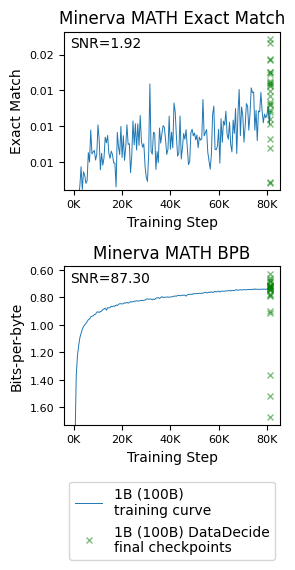

In [11]:
datadecide_1b = [model for model in DDOS_MODEL_NAMES if '1B' in model]

def format_func(x, p): return f'{int(x/1000)}K'

def _plt_intermediate_checkpoints_1b(ax: plt.Axes, task, metric, show_legend=False):
    ### Plot training curve
    step, scores = get_nd_array(
        df, ['task', 'step'], metric, model='peteish-moreeval-1B-5xC', task=task
    )
    if scores.ndim > 1:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", RuntimeWarning)
            with np.errstate(invalid='ignore', divide='ignore'):
                acc = np.nanmean(scores, axis=tuple(range(1, scores.ndim)))
    else:
        acc = scores
    
    step = np.array(step, dtype=np.float64)
    acc  = np.array(acc, dtype=np.float64)
    mask = ~np.isnan(acc)
    step = step[mask]
    acc  = acc[mask]
    
    ax.plot(step, acc, label='1B (100B)\ntraining curve', linewidth=0.7) # '1B-5xC\ntraining curve'

    ### Plot DataDecide models
    _, scores = get_nd_array(
        df, ['task', 'step', 'model'], metric, model=datadecide_1b, task=task, step='max'
    )
    if scores.ndim > 1:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", RuntimeWarning)
            with np.errstate(invalid='ignore', divide='ignore'):
                final_scores = np.nanmean(scores, axis=tuple(range(1, scores.ndim)))
    else:
        final_scores = scores
    final_scores = final_scores[~np.isnan(final_scores)]

    ax.plot([step[-1]] * len(final_scores), final_scores, 'x', color='g', markersize=4, label='1B (100B) DataDecide\nfinal checkpoints', alpha=0.5)

    # Compute SNR
    signal = np.std(final_scores[-30:]) / np.mean(final_scores[-30:])
    noise  = np.std(acc[-30:]) / np.mean(acc[-30:])
    snr = signal / noise

    ax.text(0.03, 0.97, f'SNR={snr:.2f}', transform=ax.transAxes, fontsize=10, verticalalignment='top')
    
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.xaxis.set_major_formatter(plt.FuncFormatter(format_func))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.2f}'))

    # Increase ylim
    y_min, y_max = min(final_scores), max(final_scores)
    padding = (y_max - y_min) * 0.05
    ax.set_ylim(y_min - padding, y_max + padding)
    ax.set_xlabel('Training Step')
    if show_legend == 'two_col':
        ax.legend(loc='lower center', bbox_to_anchor=(1.15, -0.7), ncols=2, fontsize=8)
    elif show_legend == 'one_col':
        ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.9), ncols=1, fontsize=10)

    return snr

# selected_tasks = [mmlu, 'gsm8k', minerva, 'mbpp']

# N_COLS = 2
# N_ROWS = math.ceil(len(selected_tasks)*2 / N_COLS)

# fig, axes = plt.subplots(N_ROWS, N_COLS, figsize=(2.5 * N_COLS, 2.5 * N_ROWS), squeeze=False)
# axes = axes.flatten()

# for i, task in enumerate(selected_tasks):
#     first_fig = (i == 0)
#     last_fig = (i == len(selected_tasks) - 1)

#     _plt_intermediate_checkpoints_1b(axes[2*i], task, metric='primary_score', show_legend=('two_col' if last_fig else None))
#     _plt_intermediate_checkpoints_1b(axes[2*i+1], task, metric='logits_per_byte_corr')
#     axes[2*i+1].invert_yaxis()

#     if get_title_from_task(task) == 'mmlu':
#         primary_metric = 'Accuracy'
#     elif get_title_from_task(task) in ['minerva', 'gsm8k']:
#         primary_metric = 'Exact Match'
#     elif get_title_from_task(task) == 'mbpp':
#         primary_metric = 'pass@1'

#     axes[2*i].set_ylabel(primary_metric)
#     axes[2*i+1].set_ylabel('Bits-per-byte')

#     axes[2*i].set_title(get_pretty_task_name(task) + f' {primary_metric}')
#     axes[2*i+1].set_title(get_pretty_task_name(task) + ' BPB')

# fig.tight_layout()
# plt.subplots_adjust(wspace=0.4)
# plt.savefig(f'{PLOT_DIR}/acc_vs_bpb.pdf', bbox_inches='tight', pad_inches=0, dpi=300)
# plt.show()

selected_tasks = [minerva]

N_COLS = 1
N_ROWS = 2

fig, axes = plt.subplots(N_ROWS, N_COLS, figsize=(3 * N_COLS, 3.2 * N_ROWS), squeeze=False)
axes = axes.flatten()

for i, task in enumerate(selected_tasks):
    first_fig = (i == 0)
    last_fig = (i == len(selected_tasks) - 1)

    _plt_intermediate_checkpoints_1b(axes[2*i], task, metric='primary_score', show_legend=None)
    _plt_intermediate_checkpoints_1b(axes[2*i+1], task, metric='logits_per_byte_corr', show_legend=('one_col' if last_fig else None))
    axes[2*i+1].invert_yaxis()

    if get_title_from_task(task) == 'mmlu':
        primary_metric = 'Accuracy'
    elif get_title_from_task(task) in ['minerva', 'gsm8k']:
        primary_metric = 'Exact Match'
    elif get_title_from_task(task) == 'mbpp':
        primary_metric = 'pass@1'

    axes[2*i].set_ylabel(primary_metric)
    axes[2*i+1].set_ylabel('Bits-per-byte')

    axes[2*i].set_title(get_pretty_task_name(task) + f' {primary_metric}')
    axes[2*i+1].set_title(get_pretty_task_name(task) + ' BPB')

    
fig.tight_layout()
plt.subplots_adjust(wspace=0.4)
plt.savefig(f'{PLOT_DIR}/acc_vs_bpb.pdf', bbox_inches='tight', pad_inches=0, dpi=300)
plt.show()

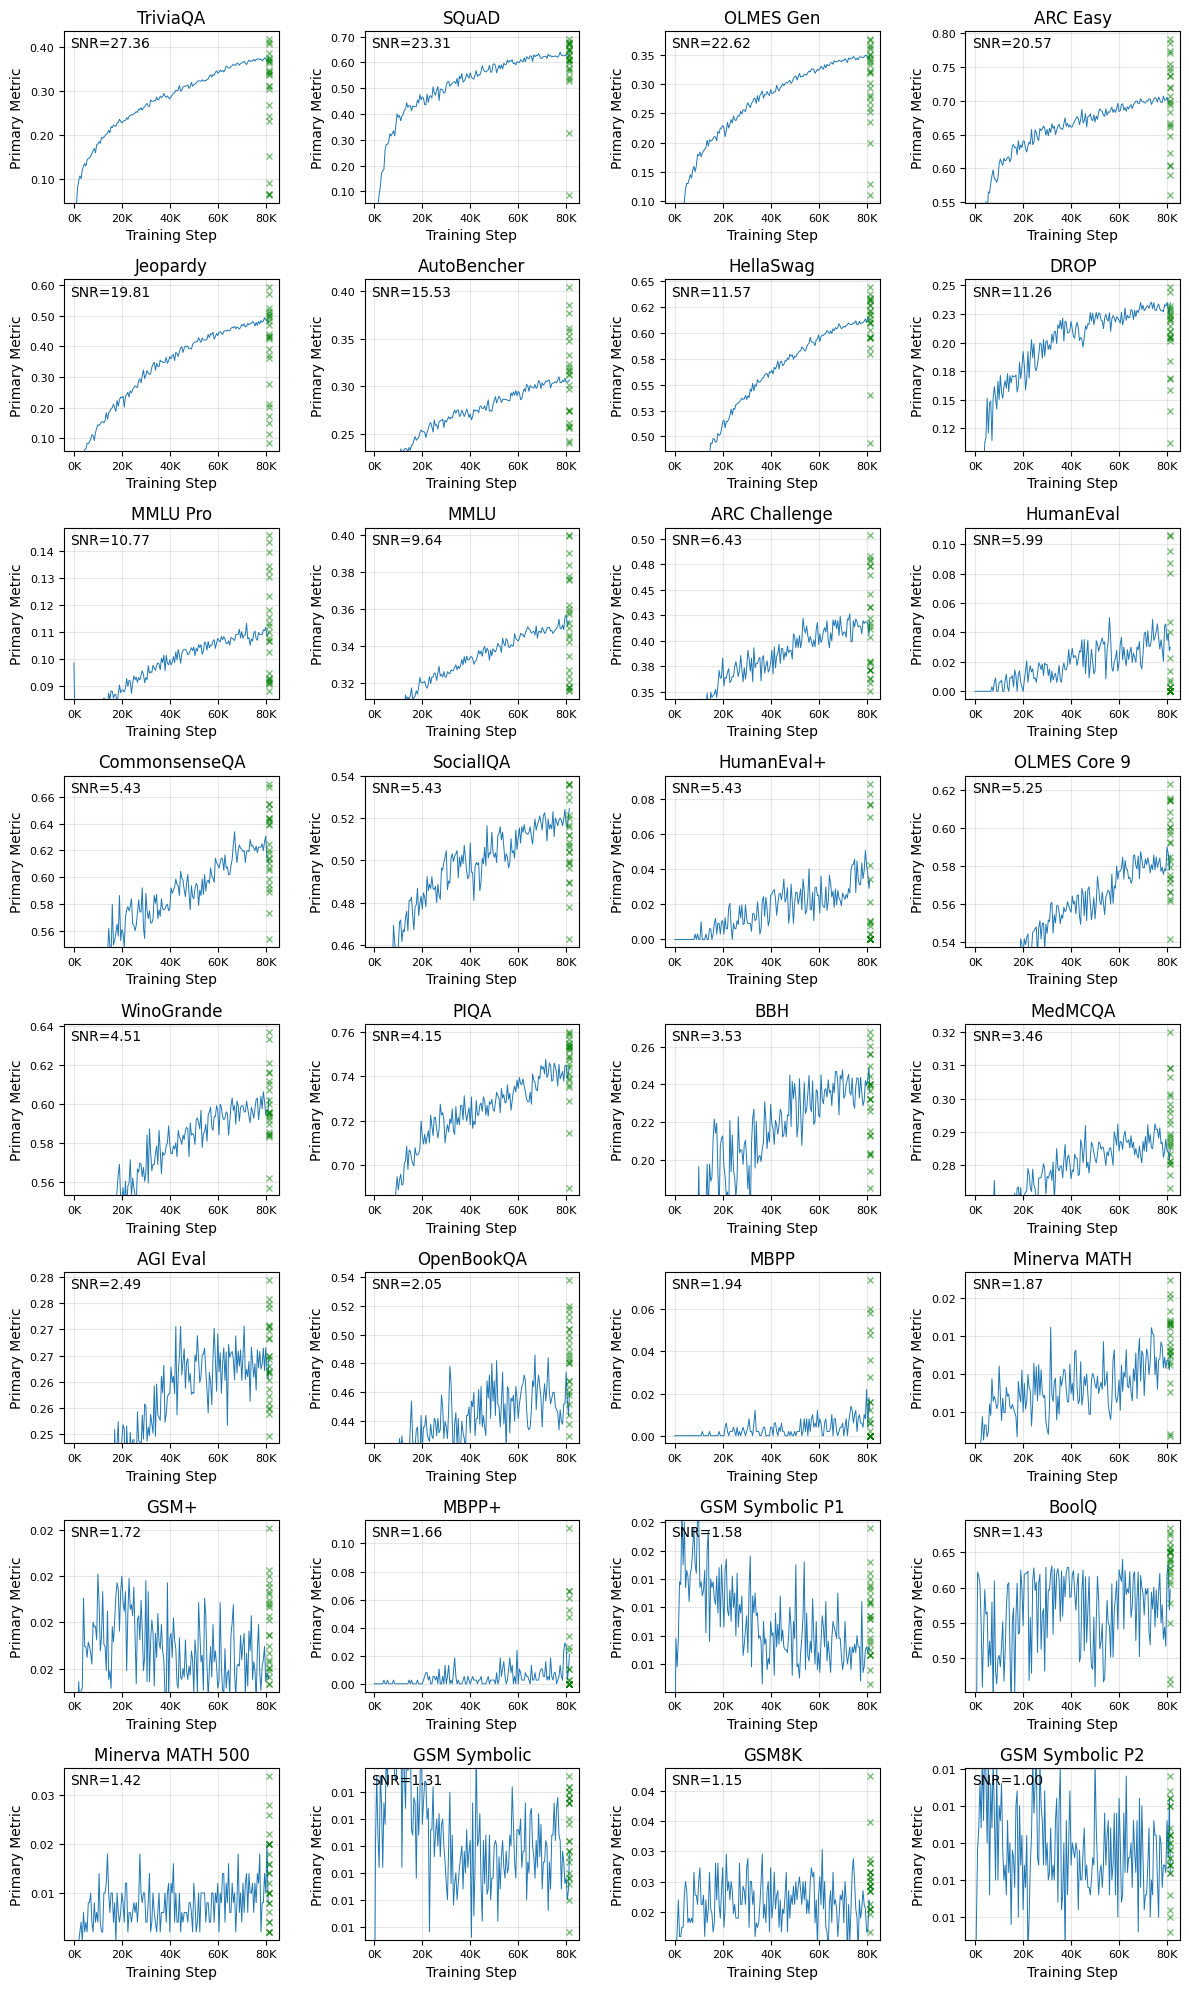

In [12]:
# selected_tasks = [
#     "arc_challenge", "arc_easy", "boolq", "csqa", "hellaswag", "openbookqa", 
#     "piqa", "socialiqa", "winogrande", "drop", "jeopardy", "squad", 
#     "triviaqa", "mbpp", "mbppplus", "codex_humaneval", "codex_humanevalplus", 
#     "autobencher",  "medmcqa", "minerva_math_500",
#     "gsm8k", "gsm_plus", "gsm_symbolic_p1", "gsm_symbolic_p2",
# ]

# selected_tasks = TASKS
selected_tasks = get_selected_tasks(TASKS)

N_COLS = 4
N_ROWS = math.ceil(len(selected_tasks) / N_COLS)

fig, axes = plt.subplots(N_ROWS, N_COLS, figsize=(3 * N_COLS, 2.5 * N_ROWS), squeeze=False)
axes = axes.flatten()

# Sort tasks by SNR
task_snrs = []
for task in selected_tasks:
    try:
        snr = _plt_intermediate_checkpoints_1b(plt.figure().add_subplot(111), task, metric='primary_score', show_legend=False)
    except Exception as e:
        snr = float('-inf')
        continue
    
    plt.close()
    task_snrs.append((task, snr))
sorted_tasks = [t for t, s in sorted(task_snrs, key=lambda x: x[1], reverse=True)]

# Plot tasks
for i, task in enumerate(sorted_tasks):
    ax = axes[i]
    first_fig = (i == 0)
    last_fig = (i == len(sorted_tasks) - 3)

    try:
        snr = _plt_intermediate_checkpoints_1b(ax, task, metric='primary_score', show_legend=last_fig)
    except Exception as e:
        snr = float('-inf')
        continue

    ax.set_ylabel('Primary Metric')
    ax.set_title(get_pretty_task_name(get_title_from_task(task)))
    ax.grid(True, linestyle='-', alpha=0.3)

# Remove empty subplots
for ax in axes[len(sorted_tasks):]:
    ax.remove()

fig.tight_layout()
plt.subplots_adjust(wspace=0.4)
plt.savefig(f'{PLOT_DIR}/step_to_step_large.pdf', bbox_inches='tight', pad_inches=0, dpi=300)
plt.show()

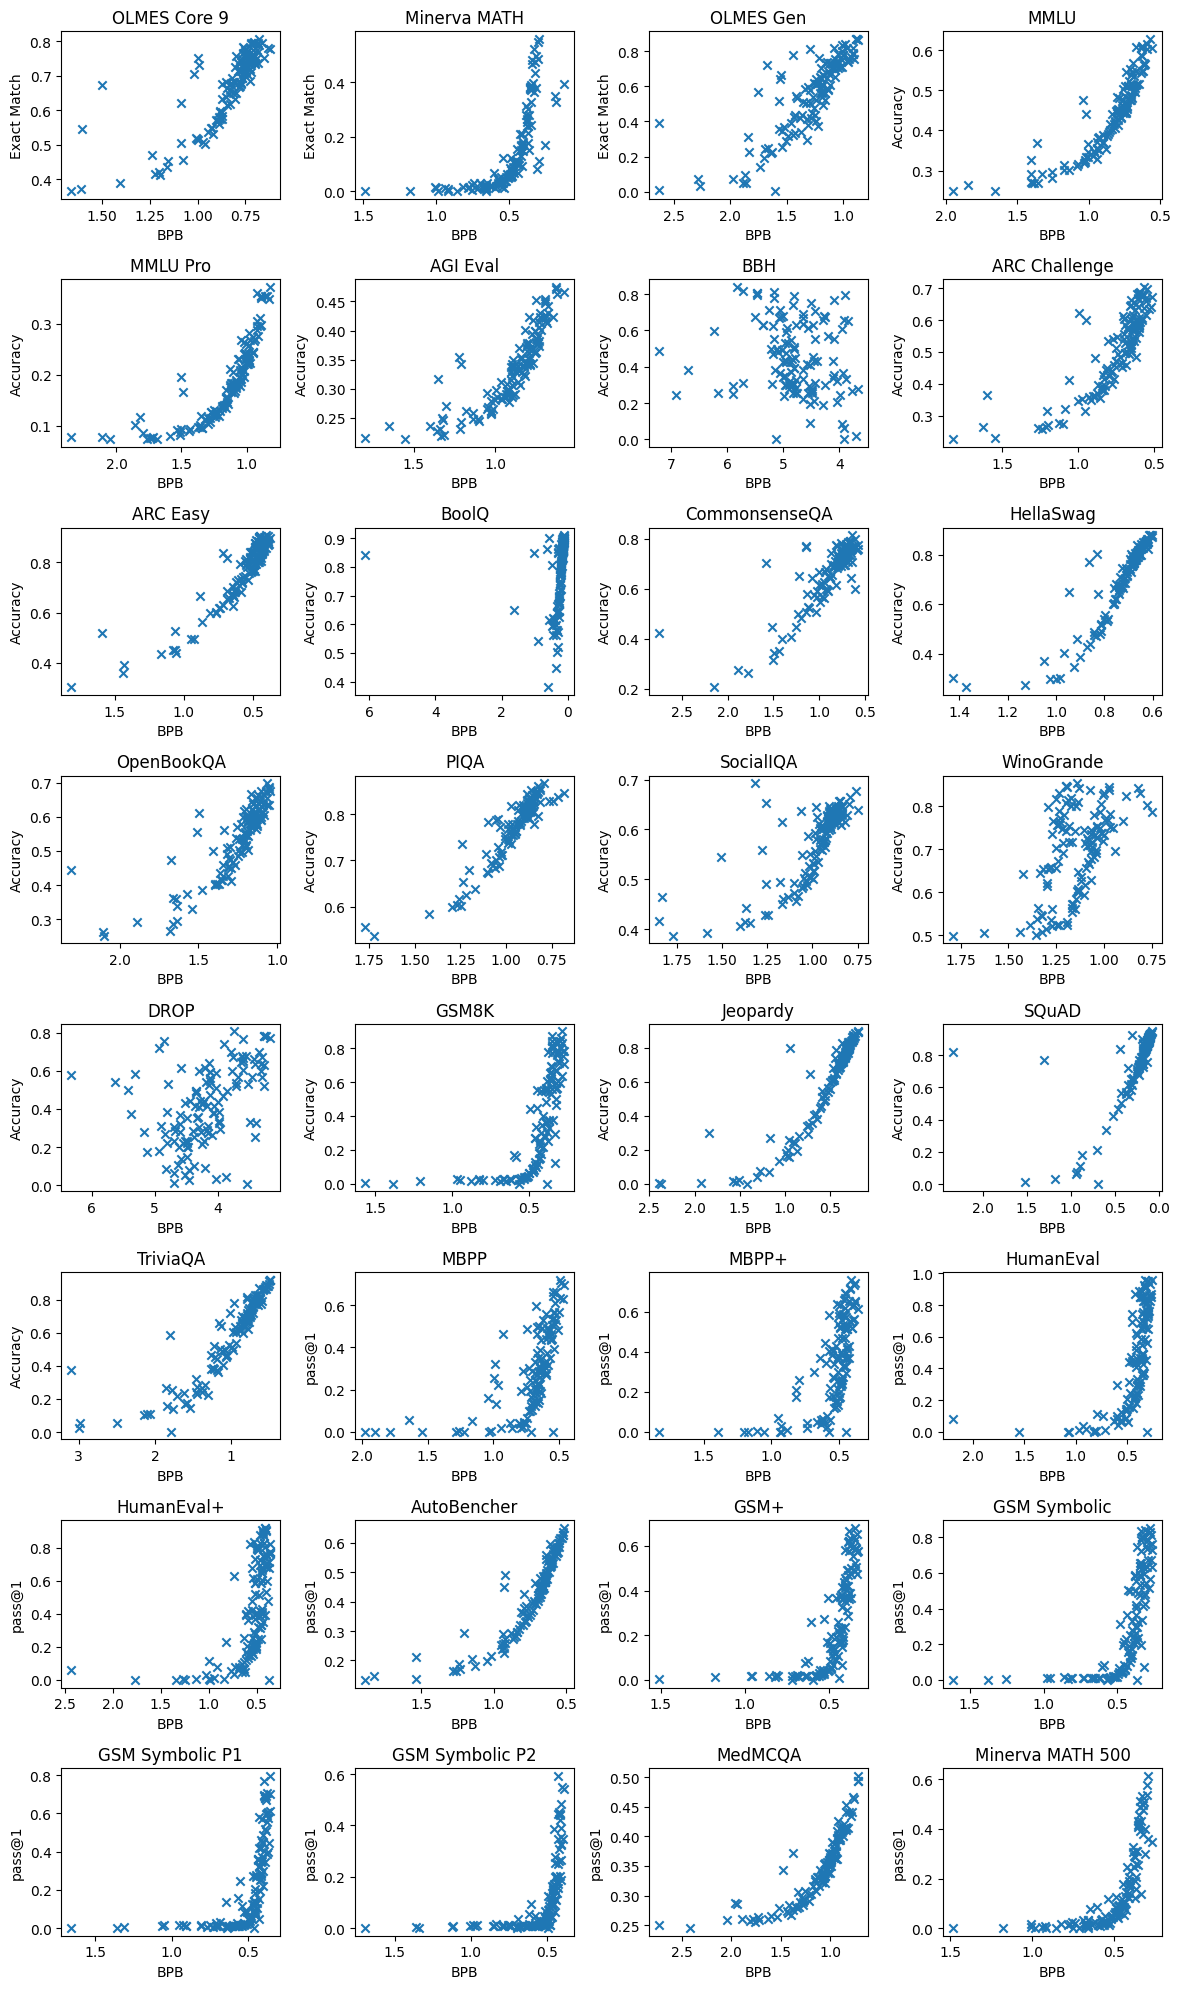

In [13]:
from metaanalysis import extract_flops

N_COLS = 4
N_ROWS = math.ceil(len(selected_tasks) / N_COLS)

fig, axes = plt.subplots(N_ROWS, N_COLS, figsize=(3 * N_COLS, 2.5 * N_ROWS), squeeze=False)
axes = axes.flatten()

for i, task in enumerate(selected_tasks):
    _slice = get_slice(df, model=external_models, task=task)

    # Macro-average tasks
    numerical_cols     = [col for col in _slice.select_dtypes(include='number').columns]
    non_numerical_cols = _slice.select_dtypes(exclude='number').columns.tolist()
    _slice = _slice.groupby('model', as_index=False).agg({col: 'mean' for col in numerical_cols} | {col: 'first' for col in non_numerical_cols})

    # Get FLOPs
    if 'flops' not in _slice.columns:
        _slice["model_path"] = _slice["model_config"].apply(lambda x: x["model_path"])
        _slice[["flops", "observational_model"]] = _slice["model_path"].apply(extract_flops).apply(pd.Series)
    
    axes[i].scatter(
        _slice['logits_per_byte_corr'],
        _slice['primary_score'] if task != 'mbpp' else _slice['pass_at_1'],
        marker='x'
    )

    if get_title_from_task(task) == 'mmlu':
        primary_metric = 'Accuracy'
    elif get_title_from_task(task) == 'minerva':
        primary_metric = 'Exact Match'
    elif get_title_from_task(task) == 'mbpp':
        primary_metric = 'pass@1'

    axes[i].set_xlabel('BPB')
    axes[i].set_ylabel(primary_metric)
    axes[i].set_title(get_pretty_task_name(task))
    axes[i].invert_xaxis()

plt.tight_layout()
plt.show()

### Observational Models

In [14]:
# benchmark_tasks = set(df['task'].unique())
# instance_tasks  = set(df_instances.index.get_level_values('task').unique())
# TASKS = sorted(list(benchmark_tasks & instance_tasks))

benchmark_tasks = set(df['task'].unique())
TASKS = sorted(list(benchmark_tasks))

In [15]:
mmlu      = [t for t in TASKS if 'mmlu' in t and ':' not in t and '_pro_' not in t]
minerva   = [t for t in TASKS if 'minerva' in t and ':' not in t and 'math_500' not in t and t != 'minerva']
mmlu_pro  = [t for t in TASKS if '_pro_' in t and ':rc' in t]
mmlu_mc   = [t for t in TASKS if 'mmlu' in t and ':mc' in t and '_pro_' not in t]
olmes     = ['arc_challenge', 'arc_easy', 'boolq', 'csqa', 'hellaswag', 'openbookqa', 'piqa', 'socialiqa', 'winogrande']
olmes_mc  = [f'{task}:mc' for task in olmes]
olmes_para        = [f'{task}:para' for task in olmes]
olmes_distractors = [f'{task}:distractors' for task in olmes]
olmes_enlarge     = [f'{task}:enlarge' for task in olmes]
# olmes_gen = ['drop', 'gsm8k', 'jeopardy', 'naturalqs', 'squad', 'triviaqa']
olmes_gen = ['drop', 'gsm8k', 'jeopardy', 'squad', 'triviaqa']
agi_eval  = [t for t in TASKS if 'agi_eval' in t and ':rc' in t]
bbh       = [t for t in TASKS if 'bbh' in t and ':' not in t]
paloma    = [t for t in TASKS if 'paloma' in t]
llm_compression = [t for t in TASKS if 'llm_compression' in t]
custom_loss = [t for t in TASKS if 'custom_loss' in t]

selected_tasks = [olmes, minerva, olmes_gen, mmlu, mmlu_pro, agi_eval, bbh] + olmes + olmes_gen + ['mbpp', 'mbppplus', 'codex_humaneval', 'codex_humanevalplus'] + ['autobencher'] + ["gsm_plus", "gsm_symbolic_main", "gsm_symbolic_p1", "gsm_symbolic_p2", "medmcqa", "minerva_math_500", "aime"]

In [16]:
from utils import extract_flops

df["model_path"] = df["model_config"].apply(lambda x: x["model_path"])
df[["flops", "observational_model"]] = df["model_path"].apply(extract_flops).apply(pd.Series)

In [17]:
df["flops"].unique()

TARGET_FLOPS = {
    'olmo2_1b': 3.6e22,
    'olmo2_7b': 1.68e23,
    'olmo2_13b': 3.9e23, 
    'olmo2_32b': 1.15e24,
}

flops = df[["flops", "model_path"]].dropna()
models_in_range = {}
for model, target in TARGET_FLOPS.items():
    lower = target / 1.7
    upper = target * 1.7
    filtered = flops[(flops['flops'] >= lower) & (flops['flops'] <= upper)]
    models_in_range[model] = {
        'count': len(filtered['model_path'].unique()),
        'flops_target': target,
        'flops_range': (lower, upper)
    }

models_in_range

{'olmo2_1b': {'count': 8,
  'flops_target': 3.6e+22,
  'flops_range': (2.1176470588235293e+22, 6.12e+22)},
 'olmo2_7b': {'count': 13,
  'flops_target': 1.68e+23,
  'flops_range': (9.88235294117647e+22, 2.8559999999999996e+23)},
 'olmo2_13b': {'count': 7,
  'flops_target': 3.9e+23,
  'flops_range': (2.2941176470588235e+23, 6.63e+23)},
 'olmo2_32b': {'count': 11,
  'flops_target': 1.15e+24,
  'flops_range': (6.764705882352941e+23, 1.955e+24)}}

In [18]:
from datadecide import get_compute
from utils.constants_models import DDOS_MODEL_NAMES

observational_models = sorted(df[df['observational_model'] == True]['model'].unique())
datadecide_models = DDOS_MODEL_NAMES

# Add FLOPs col for DataDecide
datadecide_mask = df['model'].isin(datadecide_models)
df.loc[datadecide_mask, 'flops'] = df.loc[datadecide_mask, 'size'].apply(get_compute).astype('float64')

In [19]:
MODEL_FAMILY_COLORS = {
    'codeqwen': '#2ca02c',
    'codestral': '#ff7f0e',
    'deepseek': '#1f77b4',
    'gemma': '#9467bd',
    'llama': '#d62728',
    'mathstral': '#e377c2',
    'meta': '#7f7f7f',
    'mistral': '#bcbd22',
    'mixtral': '#17becf',
    'olmo': '#8c564b',
    'orca': '#e7ba52',
    'phi': '#393b79',
    'qwen': '#637939',
    'smollm': '#b5cf6b',
    'stablelm': '#843c39',
    'yi': '#9c9ede'
}

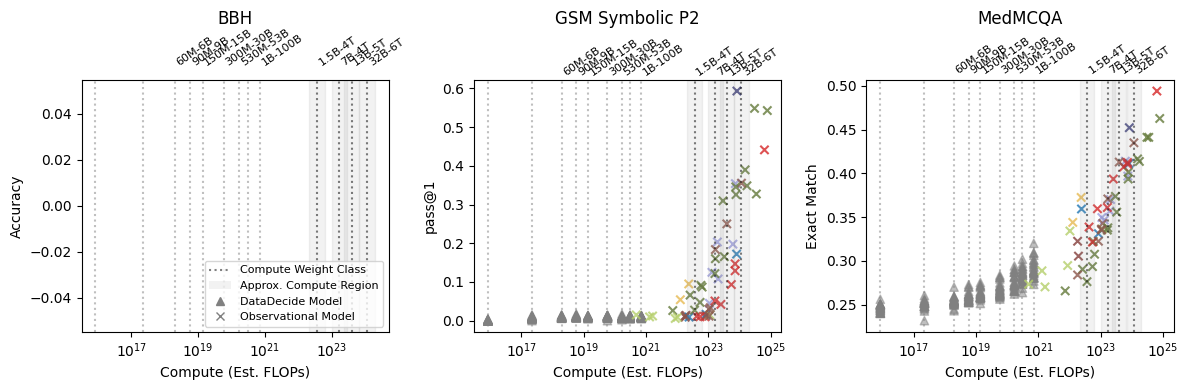

In [20]:
from plot import adjustText
from utils import get_pretty_task_name

from matplotlib.lines import Line2D
from matplotlib.patches import Patch

def plot_task(ax, task, df, observational_models, datadecide_models, models_in_range, add_region_shading=True):
    data_7b = get_slice(df, model=observational_models + datadecide_models, task=task)

    # Get colors based on model family
    colors = []
    for model in data_7b['model']:
        color = None
        for family in MODEL_FAMILY_COLORS:
            if family in model.lower():
                color = MODEL_FAMILY_COLORS[family]
                break
        colors.append(color if color else 'grey')

    # Plot DataDecide models with triangles and others with x's
    dd_mask = data_7b['model'].isin(datadecide_models)
    ax.scatter(data_7b[dd_mask]['flops'], data_7b[dd_mask]['primary_score'], 
              c=[colors[i] for i, m in enumerate(data_7b['model']) if m in datadecide_models],
              marker='^', alpha=0.5)
    ax.scatter(data_7b[~dd_mask]['flops'], data_7b[~dd_mask]['primary_score'],
              c=[colors[i] for i, m in enumerate(data_7b['model']) if m not in datadecide_models], 
              marker='x', alpha=0.8)
    
    # # Add text labels for each model point
    # texts = []
    # all_models = set()
    # for i, row in data_7b.iterrows():
    #     model_name = row['model']
    #     if model_name in all_models:
    #         continue
    #     # if len(all_models) > 30:
    #     #     continue
    #     if row['flops'] < 10**18:
    #         continue
    #     if model_name not in datadecide_models:
    #         texts.append(ax.text(
    #             row['flops'], row['primary_score'], model_name, fontsize=6
    #         ))
    #         all_models.add(model_name)

    # Add compute ranges
    labels = ['1.5B-4T', '7B-4T', '13B-5T', '32B-6T']
    for (model, info), label in zip(models_in_range.items(), labels):
        target = info['flops_target']
        lower, upper = info['flops_range']
        
        # Plot vertical dotted line at target
        ax.axvline(x=target, color='black', linestyle=':', alpha=0.5)
        
        if add_region_shading:
            # Add shaded region for range
            ymin, ymax = ax.get_ylim()
            ax.axvspan(lower, upper, alpha=0.1, color='gray')
        ax.text(target, ax.get_ylim()[1]+0.005, label, horizontalalignment='left', verticalalignment='bottom', fontsize=8, rotation=35)

    from metaanalysis import DDOS_SIZES, DDOS_COMPUTE_SIZES
    for size, compute in zip(DDOS_SIZES, DDOS_COMPUTE_SIZES):
        ax.axvline(x=compute, color='gray', linestyle=':', alpha=0.5)

        # Extract params from size and compute tokens
        if 'M' in size:
            params = float(size.replace('M','')) * 1e6
        elif 'B' in size:
            params = float(size.replace('B','')) * 1e9
        toks = f'{int(params * 100/1e9)}B'
        
        if size == '4M' or size == '20M' or size == '750M':
            continue

        ax.text(compute, ax.get_ylim()[1]+0.005, f'{size}-{toks}', 
                horizontalalignment='left', verticalalignment='bottom', 
                fontsize=8, rotation=35)

    # adjustText(ax, texts)

    ax.set_xscale('log')
    ax.set_xlabel('Compute (Est. FLOPs)')
    ax.set_title(get_pretty_task_name(task), pad=40)

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
# fig, axes = plt.subplots(1, 3, figsize=(12*2, 4*2))

# tasks = ['arc_easy', 'mbpp', 'minerva_math_500']
# tasks = ['arc_challenge', 'csqa', 'openbookqa'] 
# tasks = ['arc_challenge', 'squad', 'triviaqa']
# tasks = ['arc_easy', 'codex_humaneval', 'minerva_math_500']
# tasks = ['arc_easy', 'piqa', 'socialiqa']
tasks = ['bbh', 'gsm_symbolic_p2', 'medmcqa']
# tasks = ['codex_humaneval']

for task, ax in zip(tasks, axes):
    plot_task(ax, task, df, observational_models, datadecide_models, models_in_range)

axes[0].set_ylabel('Accuracy')
axes[1].set_ylabel('pass@1')
axes[2].set_ylabel('Exact Match')

# Add legend in top right of first ax
legend_elements = [
    Line2D([0], [0], color='black', linestyle=':', alpha=0.5, label='Compute Weight Class'),
    Patch(facecolor='gray', alpha=0.1, label='Approx. Compute Region'),
    Line2D([0], [0], marker='^', color='grey', linestyle='none', label='DataDecide Model'),
    Line2D([0], [0], marker='x', color='grey', linestyle='none', label='Observational Model')
]
axes[0].legend(handles=legend_elements, loc='lower right', fontsize=8)

plt.tight_layout()
plt.savefig(f"{PLOT_DIR}/observational_models.pdf", dpi=300, bbox_inches='tight')
plt.show()

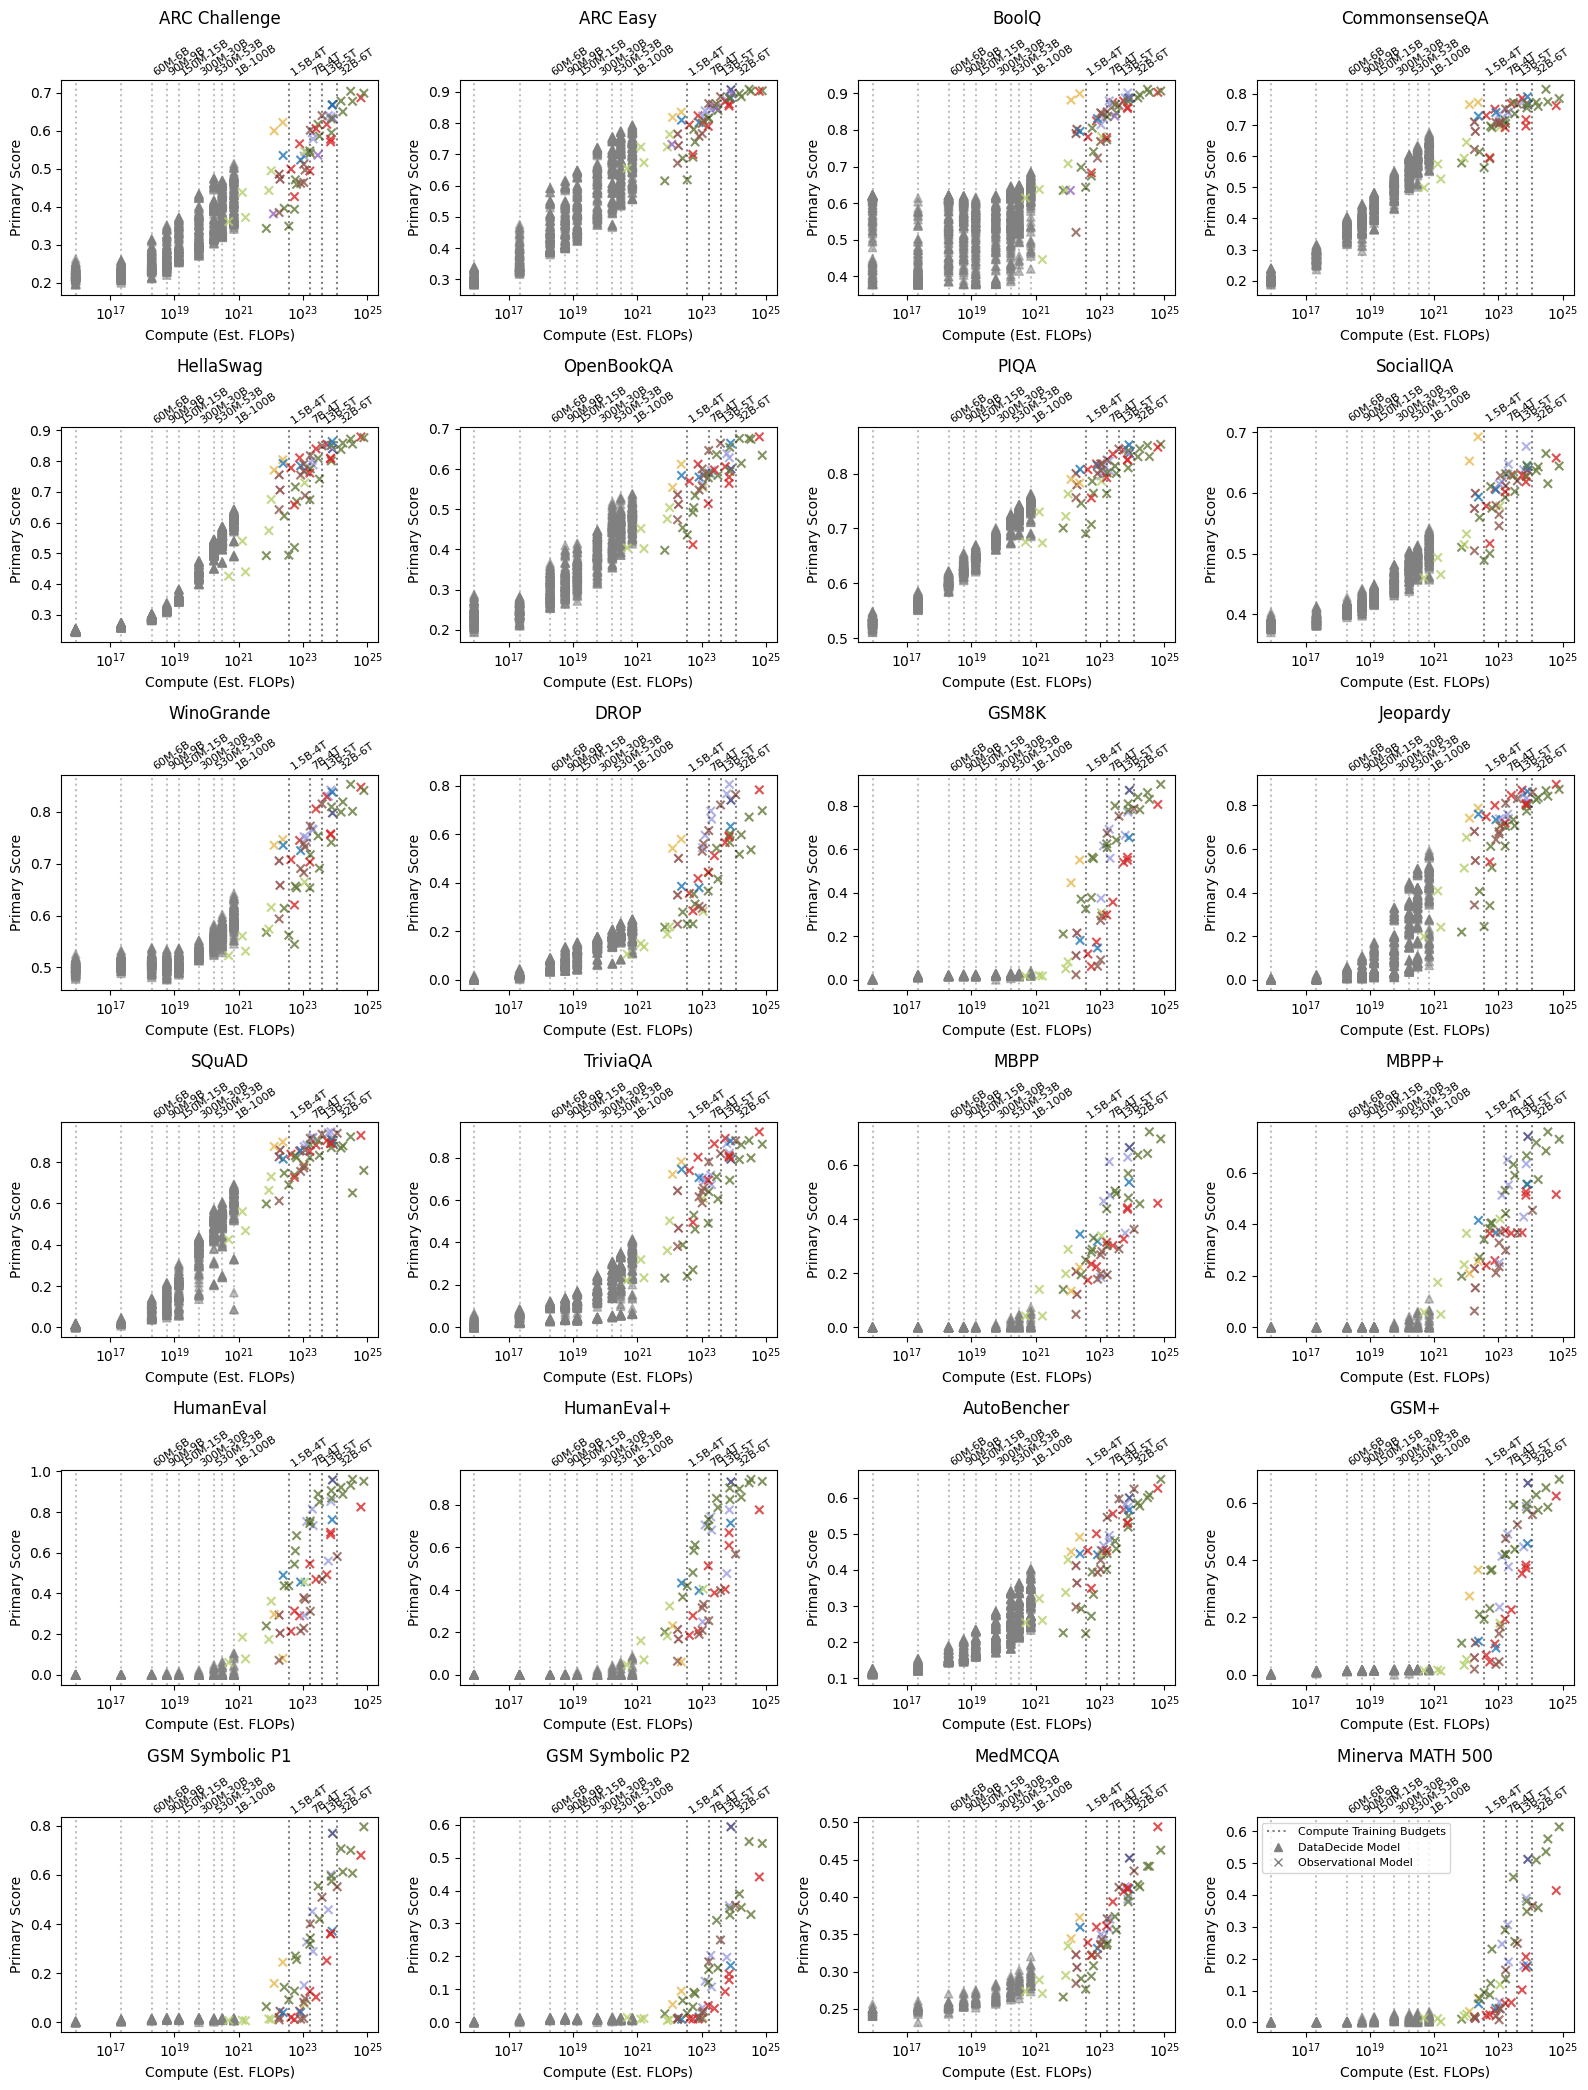

In [21]:
# tasks = ['arc_easy', 'mbpp', 'minerva_math_500']
# tasks = ['arc_challenge', 'csqa', 'openbookqa'] 
# tasks = ['arc_challenge', 'squad', 'triviaqa']
# tasks = ['arc_easy', 'codex_humaneval', 'minerva_math_500']
# tasks = ['codex_humaneval']
tasks = [task for task in selected_tasks if not isinstance(task, list) and 'aime' not in task and 'gsm_symbolic_main' not in task]

n_cols = 4
n_rows = len(tasks) // n_cols + (1 if len(tasks) % n_cols else 0)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3.5*n_rows))
axes = axes.flatten()

for task, ax in zip(tasks, axes):
    plot_task(ax, task, df, observational_models, datadecide_models, models_in_range, add_region_shading=False)

    ax.set_ylabel('Primary Score')

# Add legend in top right of first ax
legend_elements = [
    Line2D([0], [0], color='black', linestyle=':', alpha=0.5, label='Compute Training Budgets'),
    # Patch(facecolor='gray', alpha=0.1, label='Approx. Compute Region'),
    Line2D([0], [0], marker='^', color='grey', linestyle='none', label='DataDecide Model'),
    Line2D([0], [0], marker='x', color='grey', linestyle='none', label='Observational Model')
]
axes[-1].legend(handles=legend_elements, loc='upper left', fontsize=8)

plt.tight_layout()
plt.savefig(f"{PLOT_DIR}/observational_models.pdf", dpi=300, bbox_inches='tight')
plt.show()

In [22]:
# Update model column to model_path for entries with -model-merged
    # last-29-model-merged => peteish7-last-29-model-merged
mask = df['model_path'].str.contains('-model-merged', na=False)
df.loc[mask, 'model'] = df.loc[mask, 'model_path'].str.split('/').str[-2:].str.join('-')

In [23]:
_slice = get_slice(df, model=[
    'peteish7-last-30-model-merged', 'peteish7-last-5-model-merged',
    'peteish13-highlr-last-5-model-merged', 'peteish13-highlr-last-30-model-merged',
    'peteish32-last-29-model-merged', 'peteish32-last-5-model-merged'
])

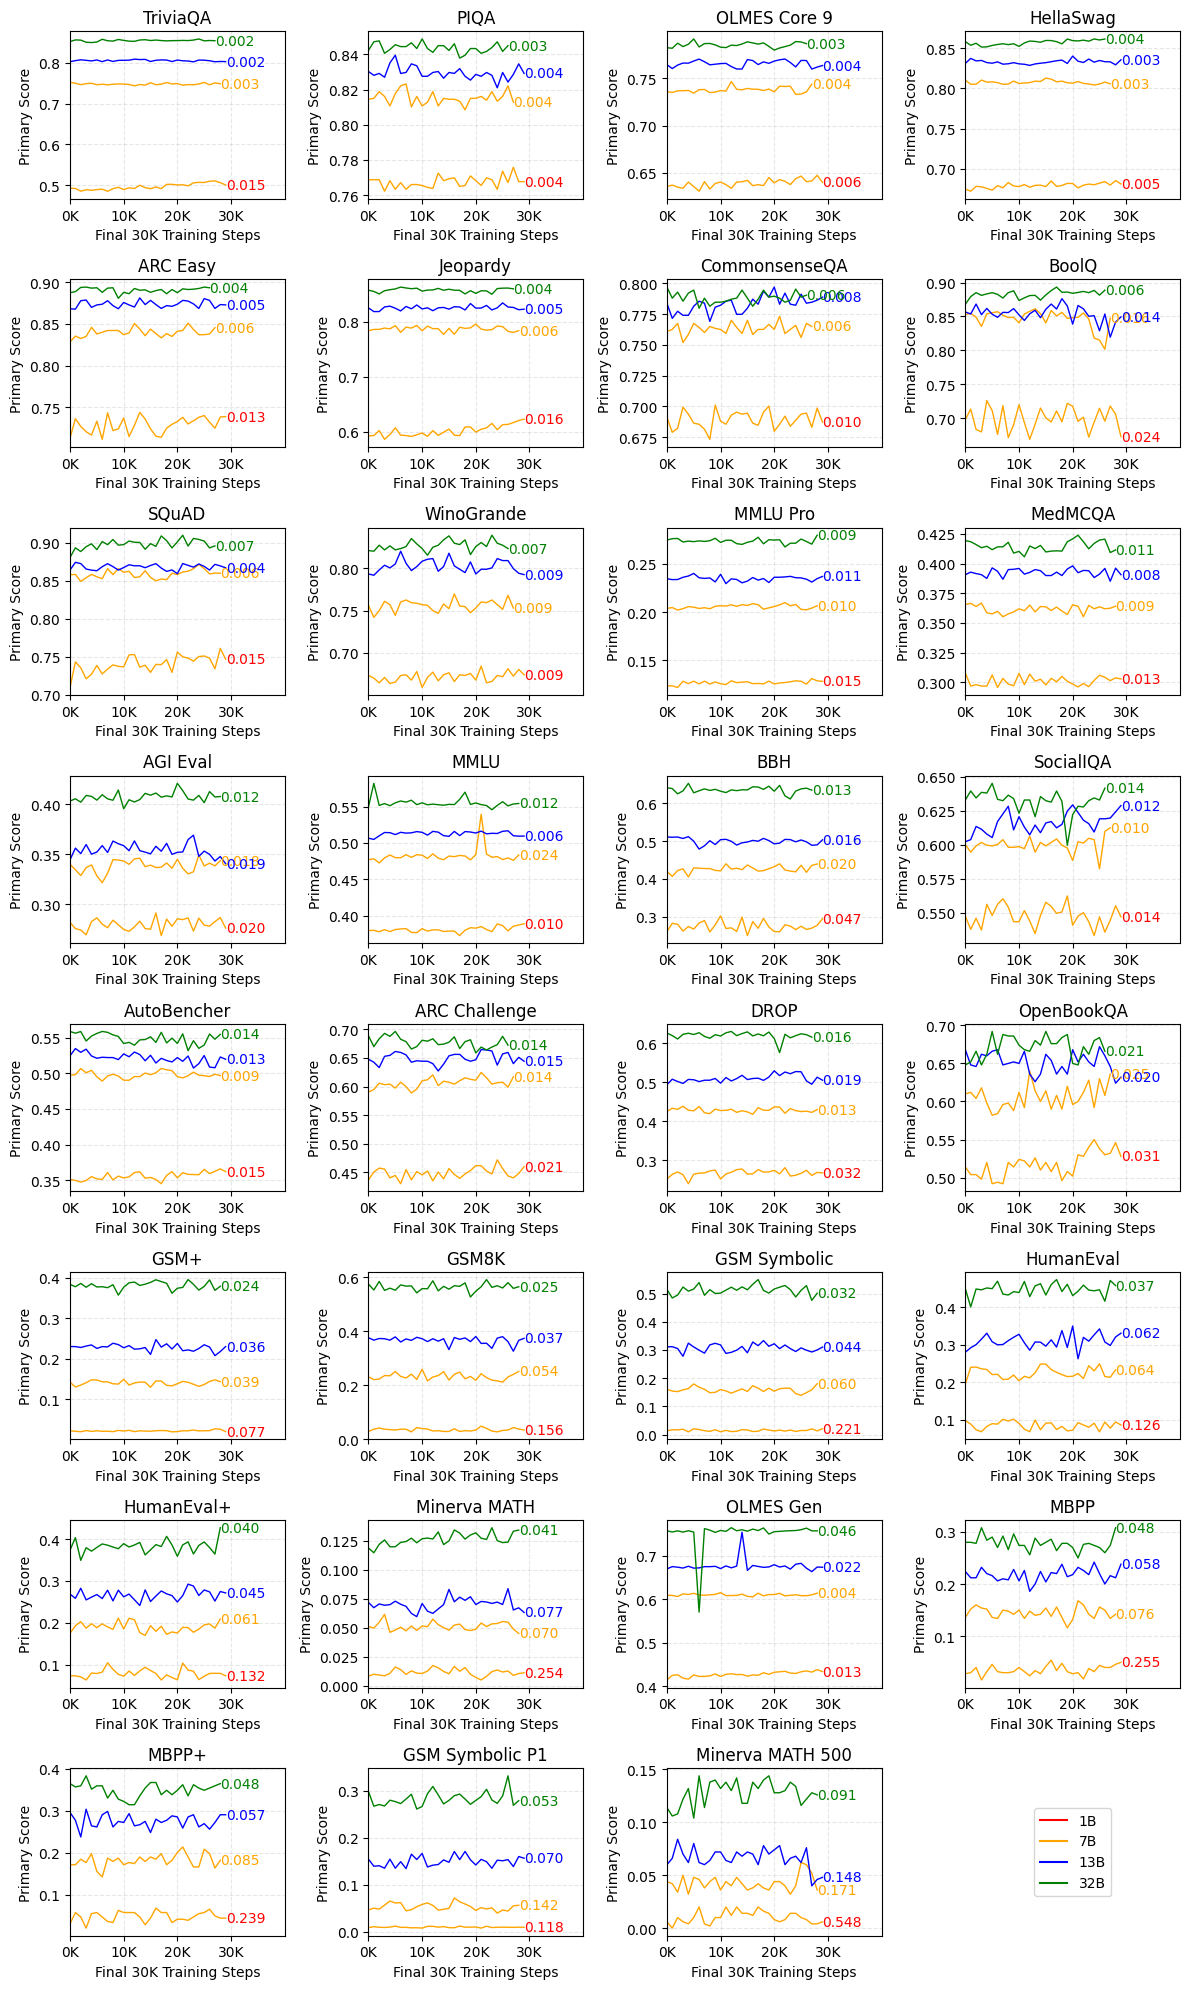

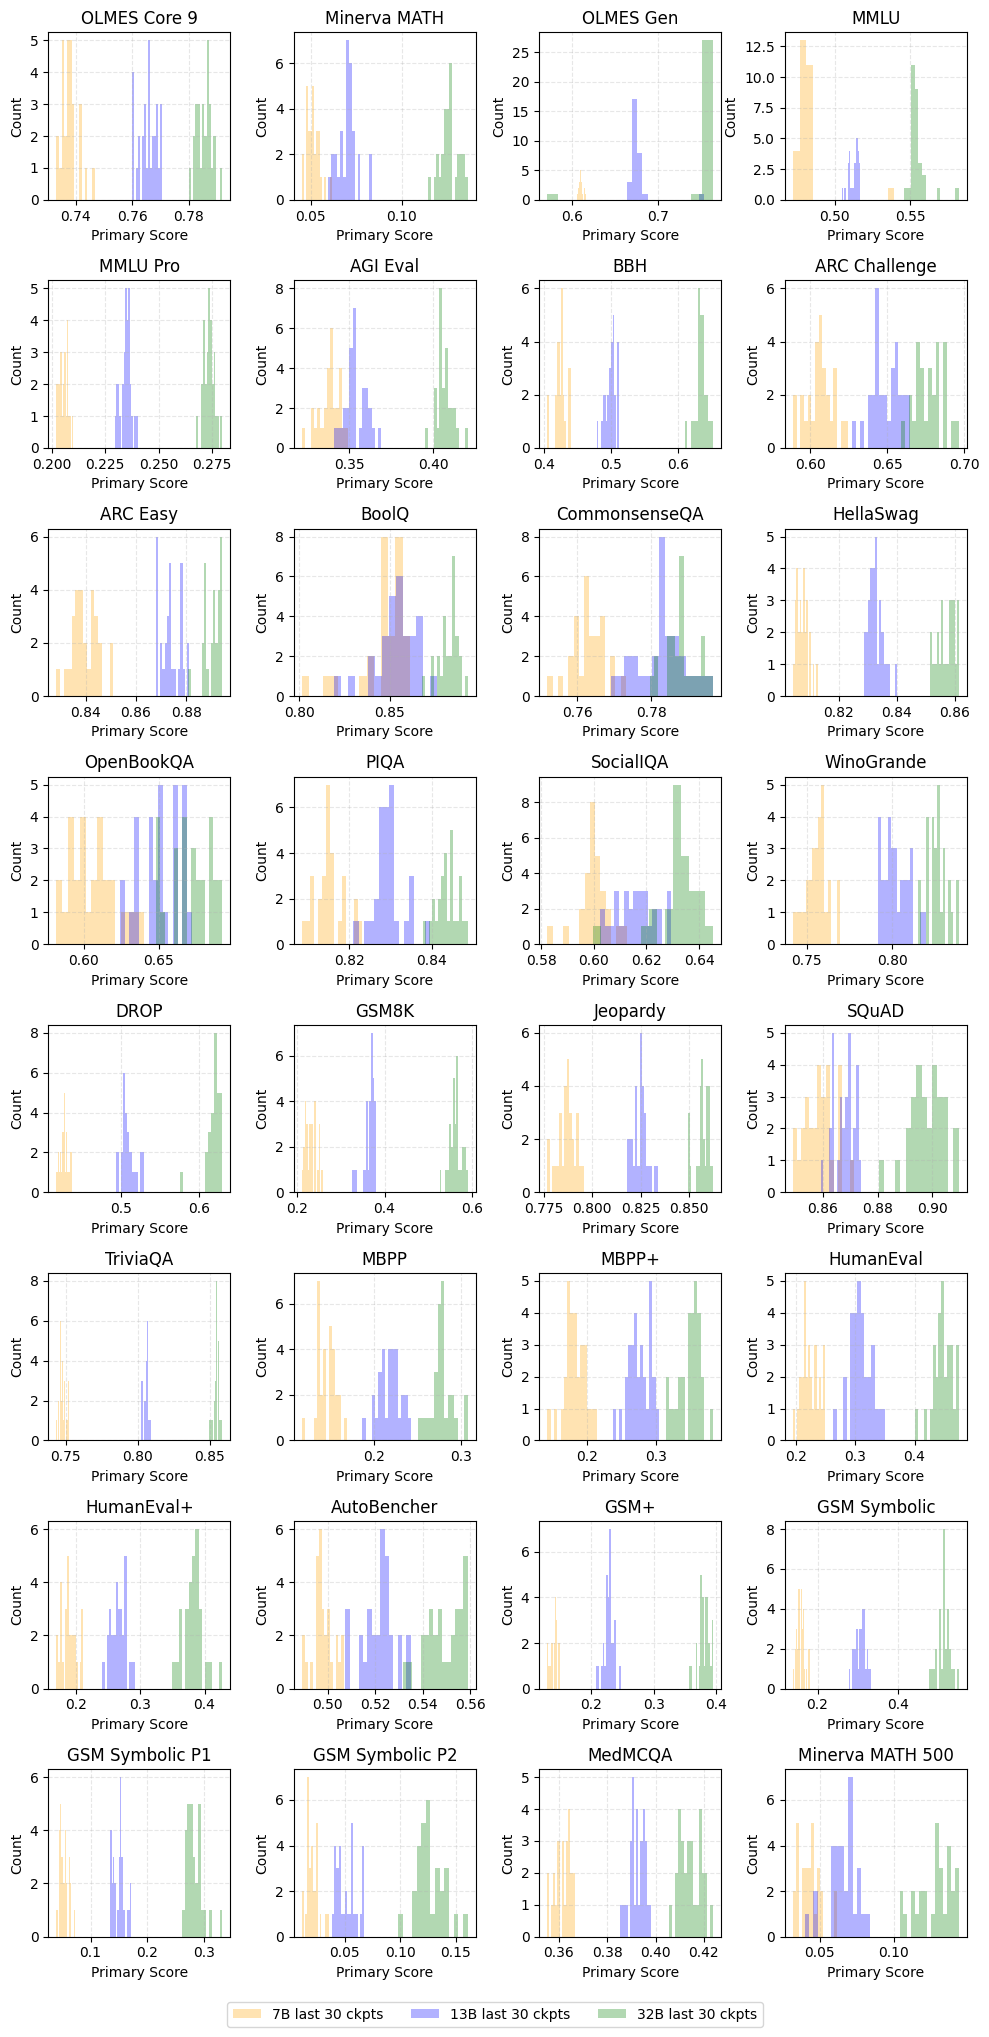

In [25]:
### FIXES ###

# Remove duplicate entries for peteish7 at step 928646.0, keeping first occurrence
mask = ~(
    (df['model'] == 'peteish7') & 
    (df['step'] == 928646.0) & 
    (df.duplicated(['model', 'step'], keep='first'))
)
df = df[mask]

# Remove peteish32 entries at step 716000.0
mask = ~(
    (df['model'] == 'peteish32') & 
    (df['step'] == 716000.0)
)
df = df[mask]

#############

def macro_avg(_slice, task_set):
    new_task = _slice.fillna('')
    new_task = new_task.groupby(['model', 'step', 'mix', 'size'])[['model_config', 'primary_score', 'logits_per_byte_corr', 'logits_per_char_corr']]
    new_task = new_task.agg(lambda x: x.iloc[0] if x.name == 'model_config' else x[pd.to_numeric(x, errors='coerce').notnull()].mean())
    new_task = new_task.reset_index()

    new_task['step'] = pd.to_numeric(new_task['step'], errors='coerce') 
    # new_task['size'] = pd.to_numeric(new_task['size'], errors='coerce')

    new_task['task'] = get_title_from_task(task_set)

    return new_task


def plot_training_progress(task, ax: plt.Axes, df, type='line', quiet=True, plot_merged=True):
    """Plot training progress for a single task across model sizes."""
    # Get the data slices for this task
    data_1b = get_slice(df, model='peteish1', task=task)
    data_7b = get_slice(df, model='peteish7', task=task)
    data_13b = get_slice(df, model='peteish13-highlr', task=task) 
    data_32b = get_slice(df, model='peteish32', task=task)

    if isinstance(task, list):
        data_1b = macro_avg(data_1b, task)
        data_7b = macro_avg(data_7b, task)
        data_13b = macro_avg(data_13b, task)
        data_32b = macro_avg(data_32b, task)

    # Sort by steps
    data_1b = data_1b.sort_values('step')
    data_7b = data_7b.sort_values('step')
    data_13b = data_13b.sort_values('step')
    data_32b = data_32b.sort_values('step')

    # Keep only last 30 steps of 13B data
    data_13b = data_13b.iloc[-30:]

    # Compute relative standard deviation (CV) for each dataset
    data_1b_cv = data_1b['primary_score'].std() / data_1b['primary_score'].mean()
    data_7b_cv = data_7b['primary_score'].std() / data_7b['primary_score'].mean()
    data_13b_cv = data_13b['primary_score'].std() / data_13b['primary_score'].mean()
    data_32b_cv = data_32b['primary_score'].std() / data_32b['primary_score'].mean()

    if ax is None:
        return data_32b_cv

    if not quiet:
        print(f"\nRelative std dev (CV) for {task}:")
        print(f"1B: {data_1b_cv:.3f}")
        print(f"7B: {data_7b_cv:.3f}")
        print(f"13B: {data_13b_cv:.3f}")
        print(f"32B: {data_32b_cv:.3f}")

    if type == 'line':
        try:
            # Plot on the corresponding subplot
            ax.plot(range(len(data_1b['step'])), data_1b['primary_score'], linewidth=1, label='7B', color='orange')
            ax.text(
                len(data_1b['step'])-1, data_1b['primary_score'].iloc[-1], 
                f'{data_1b_cv:.3f}', verticalalignment='center', color='r'
            )

            ax.plot(range(len(data_7b['step'])), data_7b['primary_score'], linewidth=1, label='7B', color='orange')
            ax.text(
                len(data_7b['step'])-1, data_7b['primary_score'].iloc[-1], 
                f'{data_7b_cv:.3f}', verticalalignment='center', color='orange'
            )

            ax.plot(range(len(data_13b['step'])), data_13b['primary_score'], linewidth=1, label='13B', color='b')
            ax.text(
                len(data_13b['step'])-1, data_13b['primary_score'].iloc[-1], 
                f'{data_13b_cv:.3f}', verticalalignment='center', color='b'
            )

            ax.plot(range(len(data_32b['step'])), data_32b['primary_score'], linewidth=1, label='32B', color='g')
            ax.text(
                len(data_32b['step'])-1, data_32b['primary_score'].iloc[-1], 
                f'{data_32b_cv:.3f}', verticalalignment='center', color='g'
            )

            if plot_merged:
                merged_models = [
                    'peteish7-last-30-model-merged', 'peteish7-last-5-model-merged',
                    'peteish13-highlr-last-5-model-merged', 'peteish13-highlr-last-30-model-merged',
                    'peteish32-last-29-model-merged', 'peteish32-last-5-model-merged'
                ]

                for model_name in merged_models:
                    data_7b_merged = get_slice(df, model=[model_name], task=task)
                    ax.scatter([len(data_7b['step'])], data_7b_merged['primary_score'], marker='*', label=model_name)
        except Exception as e:
            display(data_1b)
            print(e)

        ax.set_xlabel('Final 30K Training Steps')
        ax.set_ylabel('Primary Score')

        ax.set_xticks([0, 10, 20, 30], labels=['0K', '10K', '20K', '30K'])
        ax.set_xlim([0, 40])

    elif type == 'histogram':
        # Plot histograms for each model size
        ax.hist(data_7b['primary_score'], bins=15, alpha=0.3, label='7B last 30 ckpts', color='orange')
        ax.hist(data_13b['primary_score'], bins=15, alpha=0.3, label='13B last 30 ckpts', color='b')
        ax.hist(data_32b['primary_score'], bins=15, alpha=0.3, label='32B last 30 ckpts', color='g')

        if plot_merged:
            # Last 30 merged models
            data_merged = get_slice(df, model=['peteish7-last-30-model-merged'], task=task)
            ax.axvline(data_merged['primary_score'].iloc[0], linestyle='--', label='7B last 30 Merged', color='orange')

            data_merged = get_slice(df, model=['peteish13-highlr-last-30-model-merged'], task=task)
            ax.axvline(data_merged['primary_score'].iloc[0], linestyle='--', label='13B last 30 Merged', color='b')

            data_merged = get_slice(df, model=['peteish32-last-29-model-merged'], task=task)
            ax.axvline(data_merged['primary_score'].iloc[0], linestyle='--', label='32B last 29 Merged', color='g')

            # Last 5 merged models with lighter colors
            data_merged = get_slice(df, model=['peteish7-last-5-model-merged'], task=task)
            ax.axvline(data_merged['primary_score'].iloc[0], linestyle='--', label='7B last 5 Merged', color='bisque')

            data_merged = get_slice(df, model=['peteish13-highlr-last-5-model-merged'], task=task)
            ax.axvline(data_merged['primary_score'].iloc[0], linestyle='--', label='13B last 5 Merged', color='lightblue')

            data_merged = get_slice(df, model=['peteish32-last-5-model-merged'], task=task)
            ax.axvline(data_merged['primary_score'].iloc[0], linestyle='--', label='32B last 5 Merged', color='lightgreen')
        
        ax.set_xlabel('Primary Score')
        ax.set_ylabel('Count')

    ax.set_title(get_pretty_task_name(task))
    ax.grid(True, linestyle='--', alpha=0.3)

    return data_32b_cv

# tasks = ['arc_challenge', 'squad', 'triviaqa']
# tasks = selected_tasks
# tasks = [
#     'arc_challenge', 'arc_easy', 'csqa', 'hellaswag', 'openbookqa',
#     'piqa', 'socialiqa', 'winogrande', 'drop', 'gsm8k', 'jeopardy', 'squad',
#     'triviaqa', 'mbpp', 'mbppplus', 'codex_humaneval',
#     'codex_humanevalplus', 'autobencher', 'gsm_plus', 'gsm_symbolic_main',
#     'gsm_symbolic_p1', 'gsm_symbolic_p2', 'medmcqa', 'minerva_math_500'
# ]
# tasks = TASKS
tasks = get_selected_tasks(TASKS)

N_COLS = 4

fig, axes = plt.subplots(
    (len(tasks) + (N_COLS-1)) // N_COLS, N_COLS, 
    figsize=(3*N_COLS, 2.5 * ((len(tasks) + (N_COLS-1)) // N_COLS))
)
axes = axes.flatten()

# First, sort tasks by noise level
task_noise = []
for task in tasks:
    data_32b_cv = plot_training_progress(task, None, df, quiet=True, plot_merged=False)
    task_noise.append((task, data_32b_cv))
sorted_tasks = sorted(task_noise, key=lambda x: x[1])

# Plot tasks by noise
for i, (task, cv) in enumerate(sorted_tasks):
    plot_training_progress(task, axes[i], df, quiet=True, plot_merged=False)

for ax in axes[len(tasks):-1]:
    ax.set_visible(False)

axes[-1].clear()
axes[-1].set_frame_on(False)
axes[-1].set_xticks([])
axes[-1].set_yticks([])
axes[-1].plot([], [], color='red', label='1B')
axes[-1].plot([], [], color='orange', label='7B')
axes[-1].plot([], [], color='blue', label='13B') 
axes[-1].plot([], [], color='green', label='32B')
axes[-1].legend(loc='center')

plt.tight_layout()
plt.savefig(f'{PLOT_DIR}/step_to_step_xlarge.pdf', bbox_inches='tight', dpi=300)
plt.show()


fig, axes = plt.subplots((len(tasks) + (N_COLS-1)) // N_COLS, N_COLS, figsize=(2.5*N_COLS, 2.5 * ((len(tasks) + (N_COLS-1)) // N_COLS)))
axes = axes.flatten()
for i, task in enumerate(tasks):
    plot_training_progress(task, axes[i], df, type='histogram', quiet=True, plot_merged=False)
plt.tight_layout()
axes[-1].legend(bbox_to_anchor=(0.5, 0), loc='upper center', bbox_transform=plt.gcf().transFigure, ncols=3)
plt.show()

In [26]:
from metaanalysis import construct_2class_table

# task_names = selected_tasks
task_names = olmes + olmes_gen + ['autobencher'] # + [olmes, olmes_gen, mmlu, mmlu_pro, agi_eval]
size = '150M'

all_trial_accuracies = []
for task in task_names:
    two_class, acc_pivot_bpb_primary, metric_pivot = construct_2class_table(
        df, [task], small_metric='primary_score', target_metric='primary_score',

        model_sizes=[size],
        agg_method_pred='sample', agg_method_target='sample', n_samples=10_000
    )

    assert len(two_class) == 1
    accuracies = two_class['accuracy'][0]

    all_trial_accuracies += [accuracies]

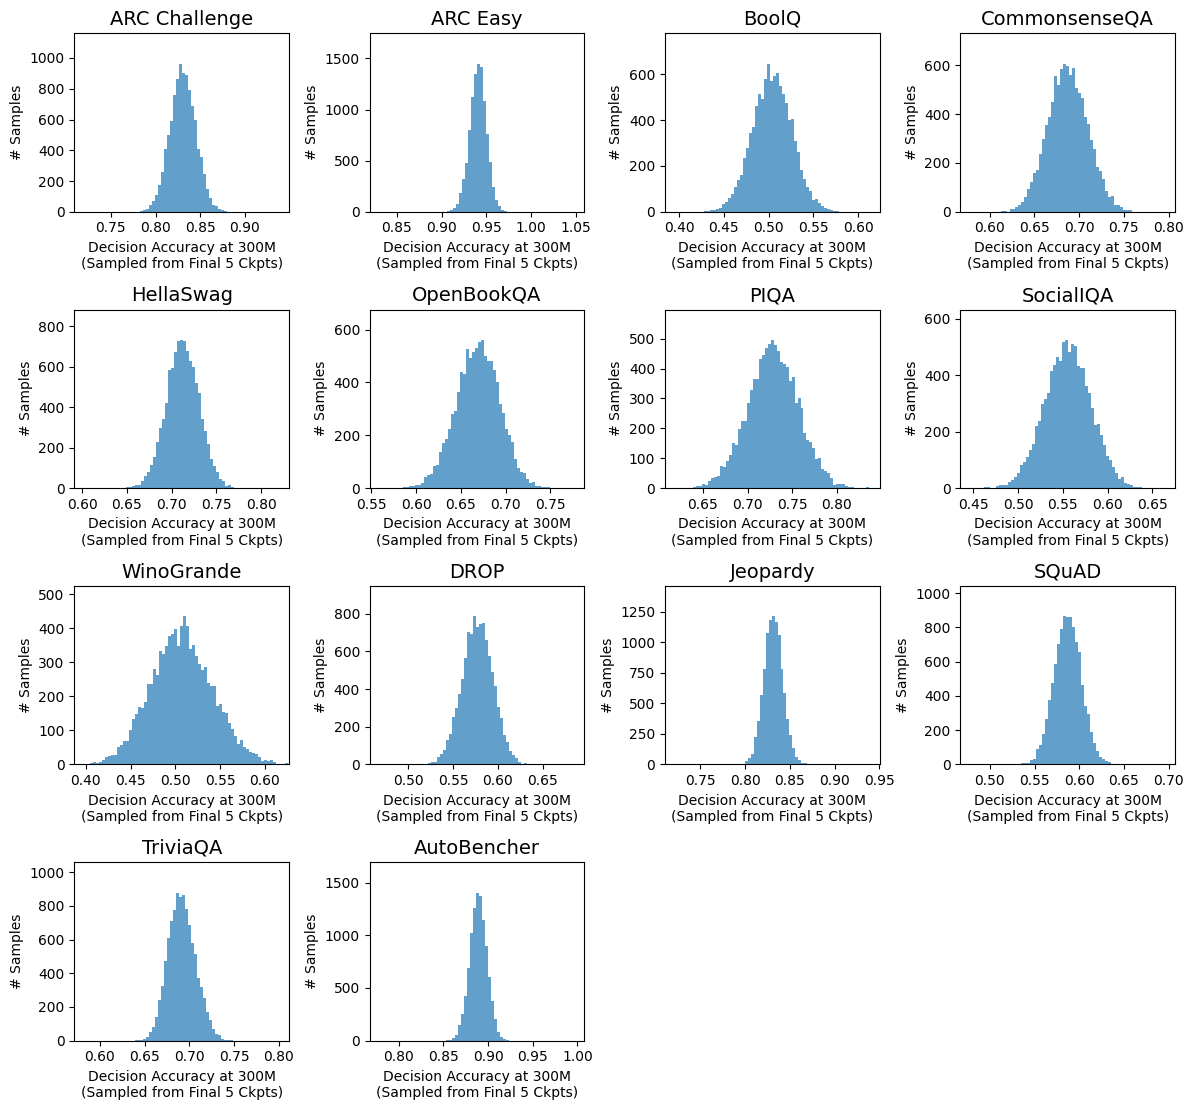

In [27]:
from pathlib import Path


N_COLS = 4

n_tasks = len(task_names)
n_cols = min(n_tasks, N_COLS)
n_rows = (n_tasks + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(3*n_cols, 2.8*n_rows))
axes = axes.flatten()

DELTA = 0.12

idx = 0
for (accuracies, task) in zip(all_trial_accuracies, task_names):
    if task == 'gsm8k':
        continue

    ax: plt.Axes = axes[idx]

    mean_acc = np.mean(accuracies)
    bins = np.linspace(0, 1, 300)
    ax.hist(accuracies, bins=bins, alpha=0.7)
    ax.set_xlabel('Decision Accuracy at 300M\n(Sampled from Final 5 Ckpts)', fontsize=10)
    ax.set_ylabel('# Samples')
    ax.set_title(get_pretty_task_name(task), fontsize=14)
    ax.set_xlim(mean_acc - DELTA, mean_acc + DELTA)

    # signal = rel_std_small_mixes[i].item()
    # noise = rel_std_small_ckpts[i].item()
    # avg_rel_std_text = (
    #     r'$\text{SNR}=' + f'{(signal/noise):.2f}' + r'_{' + f'{signal:.3f} ' + r' / ' + f' {noise:.3f}' + r'}$'
    # )
    # axes[i].text(
    #     0.5, 0.97, avg_rel_std_text,
    #     transform=axes[i].transAxes, verticalalignment='top', horizontalalignment='center',
    #     fontsize=10
    # )

    ylim = ax.get_ylim()
    ax.set_ylim(ylim[0], ylim[1] * 1.15)

    idx += 1

for j in range(idx, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.savefig(Path(PLOT_DIR) / 'decision_accuracy_distribution_large.pdf', dpi=300, bbox_inches='tight')
plt.show()